**Intelligent Ozone Alert Forecasting System**

**General Description :** 

**Role of AI:**    
For this Demo Exercise, we will be using the Ozone Level Detection Data Set build by Kun Zhang,Wei Fan and XiaoJing Yuan.  You can find the complete dataset here: \\
https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection

The task of this exercise is to determine the level of Ozone in the atmosphere on a given day and time based on sensor data like temperature, humidity, wind speed, precipitation and sea level pressure. 
The output is a binary variable with 0 standing for low ozone level and 1 standing for high ozone level.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns     
# Seaborn is a Python data visualization library based on matplotlib. 
# It provides a high-level interface for drawing attractive and informative statistical graphics.  
# we will use seaborn for visually appealing and interactive plots

# **Understanding the Data and Data Cleaning**

Dataset Information: \\
Tx: All features starting with T represent the temperature (Fahrenheit) measured at different times of the day. \\
WSRx: All features starting with WS represent wind speeds(m/s) at various times. \\
WSR_PK: peak wind speed

WSR_AV: average wind speed

T_PK: Peak T \\
T_AV: Average T \\
T85:  T at 850 hpa level (or about 1500 m height) \\
RH85: Relative Humidity at 850 hpa (in percentage) \\
U85:  (U wind - east-west direction wind at 850 hpa) \\
V85:  V wind - N-S direction wind at 850 \\
HT85: Geopotential height at 850 hpa, it is about the same as height at low altitude \\
T70:  T at 700 hpa level (roughly 3100 m height) \\
KI:  K-Index. A measure of the thunderstorm potential based on vertical temperature lapse rate, moisture content of the lower atmosphere, and the vertical extent of the moist layer. https://w1.weather.gov/glossary/index.php?letter=k  \\
TT:  T-Totals. an index used to assess storm strength. http://www.theweatherprediction.com/habyhints/302/   \\

SLP: Sea level pressure (psi) \\
SLP_: SLP change from previous day \\

Precp: precipitation \\



Output:
Result: High Ozone level(1) or Low Ozone level(0)

In [8]:
#load the .csv file using the pandas library. Assign header=0 to set the first row of the data to be the column titles.
data = pd.read_csv('/content/drive/My Drive/eighthr.csv',header=0)

In [9]:
#display the first 5 rows of the data
data.head()

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,WSR10,WSR11,WSR12,WSR13,WSR14,WSR15,WSR16,WSR17,WSR18,WSR19,WSR20,WSR21,WSR22,WSR23,WSR_PK,WSR_AV,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,RH70,U70,V70,HT70,T50,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Result
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.2,6.1,6.1,6.1,6.1,5.6,5.2,5.4,7.2,10.6,14.5,17.2,18.3,18.9,19.1,18.9,18.3,17.3,16.8,16.1,15.4,14.9,14.8,15,19.1,12.5,6.7,0.11,3.83,0.14,1612,-2.3,0.3,7.18,0.12,3178.5,-15.5,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3,2.6,3,2.2,2.3,2.5,2.8,5.5,3.4,15.1,15.3,15.6,15.6,15.9,16.2,16.2,16.2,16.6,17.8,19.4,20.6,21.2,21.8,22.4,22.1,20.8,19.1,18.1,17.2,16.5,16.1,16,16.2,22.4,17.8,9,0.25,-0.41,9.53,1594.5,-2.2,0.96,8.24,7.3,3172,-14.5,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.6,16.7,16.7,16.8,16.8,16.8,16.9,16.9,17.1,17.6,19.1,21.3,21.8,22,22.1,22.2,21.3,19.8,18.6,18,18,18.2,18.3,18.4,22.2,18.7,9,0.56,0.89,10.17,1568.5,0.9,0.54,3.8,4.42,3160,-15.9,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.3,18.2,18.3,18.4,18.6,18.6,18.5,18.7,18.6,18.8,19,19,19.3,19.4,19.6,19.2,18.9,18.8,18.6,18.5,18.3,18.5,18.8,18.9,19.6,18.7,9.9,0.89,-0.34,8.58,1546.5,3,0.77,4.17,8.11,3145.5,-16.8,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2,3,3,3.1,3.1,2.7,3,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.8,18.6,18.5,18.5,18.6,18.9,19.2,19.4,19.8,20.5,21.1,21.9,23.8,25.1,25.8,26,25.6,24.2,22.9,21.6,20,19.5,19.1,19.1,26,21.1,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.58,0


In [10]:
#get information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2534 non-null   object
 1   WSR0    2534 non-null   object
 2   WSR1    2534 non-null   object
 3   WSR2    2534 non-null   object
 4   WSR3    2534 non-null   object
 5   WSR4    2534 non-null   object
 6   WSR5    2534 non-null   object
 7   WSR6    2534 non-null   object
 8   WSR7    2534 non-null   object
 9   WSR8    2534 non-null   object
 10  WSR9    2534 non-null   object
 11  WSR10   2534 non-null   object
 12  WSR11   2534 non-null   object
 13  WSR12   2534 non-null   object
 14  WSR13   2534 non-null   object
 15  WSR14   2534 non-null   object
 16  WSR15   2534 non-null   object
 17  WSR16   2534 non-null   object
 18  WSR17   2534 non-null   object
 19  WSR18   2534 non-null   object
 20  WSR19   2534 non-null   object
 21  WSR20   2534 non-null   object
 22  WSR21   2534 non-null   

In [11]:
#the date column serves no purpose for the analysis. Hence we drop it from the data, inplace=True shifts all the other columns to the left
data.drop(columns='Date', inplace=True)

The real world data may be messy or corrupted. You may have to use various techinques to clean the dataset. 
Notice that the data contains lot of '?' as the elements. These are the values which were missing in the data.
we will replace all '?' with NaN as it is easier to work with NaN's than with '?'  
Read fore more details : ** https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer **

In [12]:
#use the .replace() to replace all instances of '?' with NaN
data.replace(to_replace='?', value=np.nan, inplace=True)

In [13]:
#You can check if there are any NaN values in the features using .isna() function
print(data["T_PK"].isna().value_counts())

False    2359
True      175
Name: T_PK, dtype: int64


In [14]:
# We will only be using a few features for the analysis. Here we split the data into input features and output response. 
#instead of specifying indices, if the columns are labelled, you can 
#select them by just specifying their names. This is particularly useful when you have to pick only a certain features out of 100s of given features.
X = data[['WSR_AV','T_AV','T85','RH85','SLP','Precp']] 
Y = data.iloc[:,-1].values  #select the last column as the output variable

Now that we have our Input and Output Variables set, the next task is to deal with the NaN values in the input. Previously we dealt with NaN by dropping out the rows that contained NaN. This is a very simple approach and works fine for most data. 

But in a situation where the amount of data is already scarce, it would be infeasible to drop additional rows from it. Hence we need another strategy to deal with such a situation. 

Here we use a simple but highly efficient method of replacing all the NaN values in a column by the mean value of the column. Though not an acccurate representation of the values, this method still gives very good results.

In [15]:
#we will make use of sklearn's SimpleImputer function to replace the NaN with the mean values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')   #missing_values are the NaN which need to be replace. Strategy refers to the method to use
#other strategies to use are - median, highest frequency value, constant value assigned by user.

In [16]:
#use the imputer instance to transform the data
data = pd.DataFrame(imputer.fit_transform(data), dtype='float64')
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,3.7,5.5,5.1,5.4,5.4,4.7,4.3,3.5,3.5,2.9,3.2,3.2,2.8,2.6,5.5,3.1,5.2,6.1,6.1,6.1,6.1,5.6,5.2,5.4,7.2,10.6,14.5,17.2,18.3,18.9,19.1,18.9,18.3,17.3,16.8,16.1,15.4,14.9,14.8,15.0,19.1,12.5,6.700000,0.11000,3.830000,0.140000,1612.00000,-2.300000,0.300000,7.180000,0.120000,3178.500000,-15.50000,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,0.0
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,4.2,4.5,4.5,4.3,5.5,5.1,3.8,3.0,2.6,3.0,2.2,2.3,2.5,2.8,5.5,3.4,15.1,15.3,15.6,15.6,15.9,16.2,16.2,16.2,16.6,17.8,19.4,20.6,21.2,21.8,22.4,22.1,20.8,19.1,18.1,17.2,16.5,16.1,16.0,16.2,22.4,17.8,9.000000,0.25000,-0.410000,9.530000,1594.50000,-2.200000,0.960000,8.240000,7.300000,3172.000000,-14.50000,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,0.0
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,3.1,4.0,4.4,4.6,5.6,5.4,5.2,4.4,3.5,2.7,2.9,3.9,4.1,4.6,5.6,3.5,16.6,16.7,16.7,16.8,16.8,16.8,16.9,16.9,17.1,17.6,19.1,21.3,21.8,22.0,22.1,22.2,21.3,19.8,18.6,18.0,18.0,18.2,18.3,18.4,22.2,18.7,9.000000,0.56000,0.890000,10.170000,1568.50000,0.900000,0.540000,3.800000,4.420000,3160.000000,-15.90000,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,0.0
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,3.3,3.1,2.3,2.1,2.2,3.8,2.8,2.4,1.9,3.2,4.1,3.9,4.5,4.3,4.7,3.2,18.3,18.2,18.3,18.4,18.6,18.6,18.5,18.7,18.6,18.8,19.0,19.0,19.3,19.4,19.6,19.2,18.9,18.8,18.6,18.5,18.3,18.5,18.8,18.9,19.6,18.7,9.900000,0.89000,-0.340000,8.580000,1546.50000,3.000000,0.770000,4.170000,8.110000,3145.500000,-16.80000,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,0.0
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,2.2,2.0,3.0,3.0,3.1,3.1,2.7,3.0,2.4,2.8,2.5,2.5,3.7,3.4,3.7,2.3,18.8,18.6,18.5,18.5,18.6,18.9,19.2,19.4,19.8,20.5,21.1,21.9,23.8,25.1,25.8,26.0,25.6,24.2,22.9,21.6,20.0,19.5,19.1,19.1,26.0,21.1,13.575298,0.57732,2.136487,1.662464,1531.49426,5.931129,0.406445,5.459634,0.994001,3145.420501,-10.51141,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,0.0


In [17]:
#transform X by replacing the NaN values and converting it into a pandas DataFrame
X = pd.DataFrame(imputer.fit_transform(X))
#Assign Column Labels to each column of X
X.columns=['Average Wind Speed','Average Temperature','Temeperature at 85 hpa','Relative Humidity at 85hpa','Sea Level Pressure','Precipitation']
X

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
0,3.1,12.5,6.700000,0.11000,10330.000000,0.00
1,3.4,17.8,9.000000,0.25000,10275.000000,0.00
2,3.5,18.7,9.000000,0.56000,10235.000000,0.00
3,3.2,18.7,9.900000,0.89000,10195.000000,2.08
4,2.3,21.1,13.575298,0.57732,10164.198442,0.58
...,...,...,...,...,...,...
2529,1.6,7.7,5.500000,0.33000,10295.000000,0.00
2530,2.6,12.9,5.800000,0.27000,10310.000000,0.00
2531,1.9,17.7,7.500000,0.79000,10275.000000,0.00
2532,2.1,19.9,9.300000,0.66000,10245.000000,0.05


In [18]:
X.shape

(2534, 6)

# **Data Visualization**

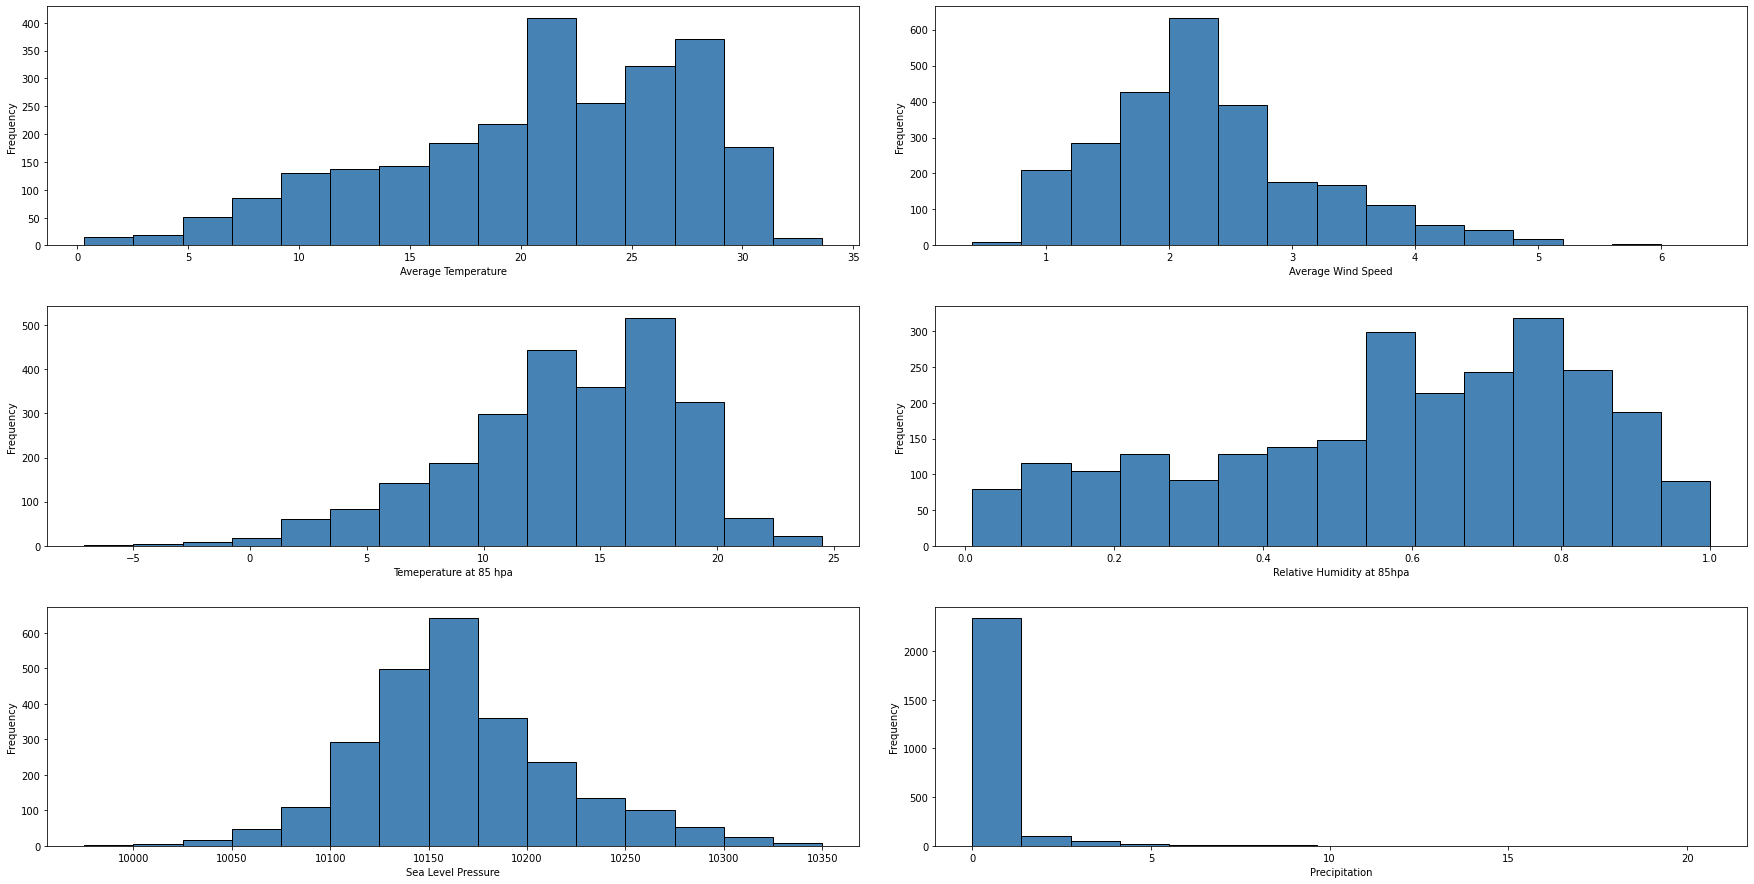

In [60]:
#plot the histogram of all the input variables.
#freq: is the number of counts in each bin of the histogram
#bins: is the left hand edge of each bin
#patches: is the individual patches used to create the histogram, e.g a collection of rectangles

fig = plt.figure(figsize = (25,25))
#fig.subplots_adjust(top=0.85, wspace=0.3)

# Histogram
ax = fig.add_subplot(6, 2, 1)
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Average Temperature'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(6, 2, 2)
ax.set_xlabel("Average Wind Speed")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Average Wind Speed'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(6, 2, 3)
ax.set_xlabel("Temeperature at 85 hpa")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Temeperature at 85 hpa'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(6, 2, 4)
ax.set_xlabel("Relative Humidity at 85hpa")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Relative Humidity at 85hpa'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(6, 2, 5)
ax.set_xlabel("Sea Level Pressure")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Sea Level Pressure'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)

ax = fig.add_subplot(6, 2, 6)
ax.set_xlabel("Precipitation")
ax.set_ylabel("Frequency") 
freq, bins, patches = ax.hist(X['Precipitation'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)
fig. tight_layout(pad=3.0)

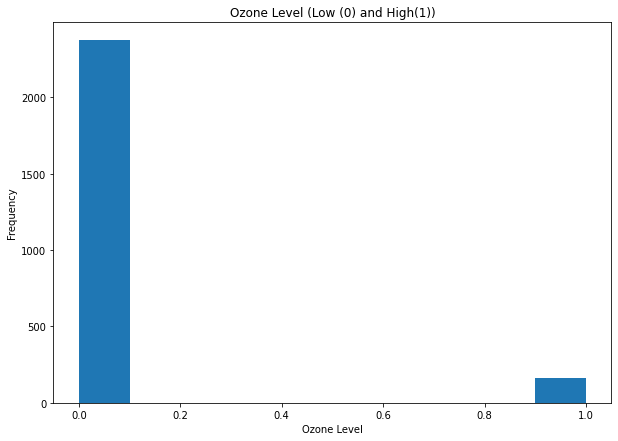

In [33]:
fig = plt.figure(figsize =(10, 7)) 
  
plt.hist(Y)  
plt.xlabel('Ozone Level')
plt.ylabel('Frequency')  
plt.title("Ozone Level (Low (0) and High(1))")  
  
# show plot 
plt.show() 

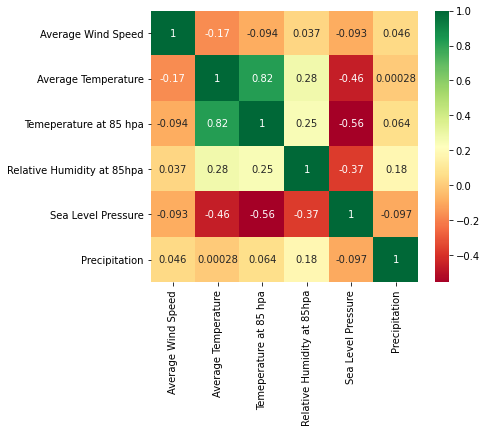

In [34]:
#plot the correlation between input variables using a heat map.
#heat map assigns colors related to how high or low the value in each cell is. The colormap on the right gives the distribution.
plt.figure(figsize=(6,5))  # set the size of the figure 
p=sns.heatmap(X.corr(), annot=True,cmap ='RdYlGn')  # we use the seaborn library to plot the heatmap.

# We need to explain them how to interpret this graph and how it is benefecial in the analysis? 

In [35]:
#in the previous tutorial we used to calculate the mean and variance of each input feature separately. This is not feasible when the number of features
#increase. Hence we will use the built in command in pandas to describe all the properties of the features.
X.describe()

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,2.314949,20.840483,13.575298,0.577320,10164.198442,0.372026
std,0.871756,6.766376,4.777721,0.252778,51.428116,1.317438
min,0.400000,0.300000,-7.100000,0.010000,9975.000000,0.000000
25%,1.700000,16.500000,10.700000,0.400000,10130.000000,0.000000
50%,2.300000,21.400000,14.100000,0.620000,10160.000000,0.000000
75%,2.800000,26.500000,17.300000,0.790000,10190.000000,0.050000
max,6.400000,33.600000,24.500000,1.000000,10350.000000,20.650000


# **Naive Bayes**

In [36]:
#import MultinomialNB from sklearn library. 
from sklearn.naive_bayes import MultinomialNB

**Data Preprocessing for Naive Bayes**

We need to scale the input such that its values fall in the range [0,1]. We will use normalization technique to achieve this result. 

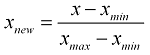

In [37]:
#we will use the built in MinMaxScaler to scale the inputs to [0,1]
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(X))
x_scaled.head()

,0,1,2,3,4,5
0,0.450000,0.366366,0.436709,0.101010,0.946667,0.000000
1,0.500000,0.525526,0.509494,0.242424,0.800000,0.000000
2,0.516667,0.552553,0.509494,0.555556,0.693333,0.000000
3,0.466667,0.552553,0.537975,0.888889,0.586667,0.100726
4,0.316667,0.624625,0.654282,0.573050,0.504529,0.028087


In [38]:
#split the data into train and test. Test data=1/3(total data)
from sklearn.model_selection import train_test_split 
X_train1,X_test1,y_train1,y_test1 = train_test_split(x_scaled,Y,test_size=1/3,random_state=42, stratify=Y)

#create an instance of MultinomialNB class
model=MultinomialNB()

#fit the training data 
model.fit(X_train1, y_train1)

# you get the conditional probabilities

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
#get the predicted labels for test data
labels = model.predict(X_test1)

In [40]:
#predict the accuracy of the model on test data
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test1, labels)
print(score)

0.9372781065088758


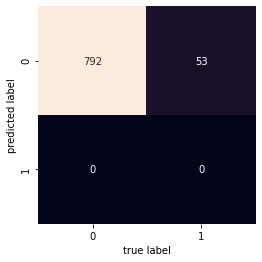

In [41]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test1, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [42]:
#import classification_report- (Precision, Recall, F1-score and support)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test1,labels))

#The metric "Support" here gives the number of occurrences of each class. 
# Precision = tp / (tp + fp)
# Recall =  tp / (tp + fn)
# F-score = weighted harmonic mean of the precision and recall,
#precision  - 792 /(792+53) = 0.937 ~ 0.94
#Recall - 792/(792+0) = 1
# Support - it gives count, so 792 instances are classified in class 0 and 53 are classified in class 1 
#For more details to understand this table, please refer to the sklearn user guide. 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       792
           1       0.00      0.00      0.00        53

    accuracy                           0.94       845
   macro avg       0.47      0.50      0.48       845
weighted avg       0.88      0.94      0.91       845



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#get the count of Y=0 samples and Y=1 samples
#print(len(y_train))
#Y_plus=np.count_nonzero(y_train)
#Y_zero=len(y_train)-Y_plus
#print(Y_plus,Y_zero)

The Naive Bayes Completely Failed to classify any samples of class 1. This is because the prior P(Y=0) is very high as compared to P(Y=1).

P(Y=0)=1582/1689 = 0.936 \\
P(Y=1)=107/1689 = 0.063

Hence in every test case, the conditional probability P(Y=0/X) dominated.

# **K-Nearest Neighbours Algorithm**

**Data Preprocessing for k-Nearest Neighbours**

As we studied in the lecture, standardization of input features in very important before computing the Euclidean distance. This is to ensure that one feature with very large values does not end up dominating the distance term, rendering all other features useless. \\
Here you can see the feature SLP (sea level pressure) to be in 10,000's whereas all other features are less than 100. What do you think will happen if you do not standardize the data? 

There are various ways of standarizing the data. 
1. Transform all features to lie between [0,1] or [-1,1]
2. Subtract the mean and divide by standard deviation to get a 0 mean and unit standard deviation.  

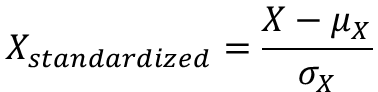

Input X and output Y are from the Naive Bayes exercise ( We are continuing with the same dataset)

In [43]:
#standardizing the input
x_std = (X-X.mean())/(X.std()) 

In [44]:
x_std.head()

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
0,0.900540,-1.232637,-1.439033e+00,-1.848735e+00,3.223948e+00,-0.282386
1,1.244673,-0.449352,-9.576318e-01,-1.294890e+00,2.154494e+00,-0.282386
2,1.359384,-0.316341,-9.576318e-01,-6.851811e-02,1.376709e+00,-0.282386
3,1.015251,-0.316341,-7.692575e-01,1.236974e+00,5.989245e-01,1.296436
4,-0.017148,0.038354,-7.436000e-16,5.709709e-15,-2.829564e-13,0.157862


In [45]:
x_std. describe()

,Average Wind Speed,Average Temperature,Temeperature at 85 hpa,Relative Humidity at 85hpa,Sea Level Pressure,Precipitation
count,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03
mean,-2.569658e-15,-2.704097e-14,-1.028643e-15,5.797476e-15,-2.732839e-13,8.704560e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.196657e+00,-3.035670e+00,-4.327439e+00,-2.244339e+00,-3.678891e+00,-2.823860e-01
25%,-7.054143e-01,-6.414783e-01,-6.018136e-01,-7.014841e-01,-6.649756e-01,-2.823860e-01
50%,-1.714831e-02,8.269076e-02,1.098227e-01,1.688441e-01,-8.163709e-02,-2.823860e-01
75%,5.564067e-01,8.364178e-01,7.795981e-01,8.413704e-01,5.017014e-01,-2.444335e-01
max,4.686003e+00,1.885724e+00,2.286593e+00,1.672138e+00,3.612840e+00,1.539197e+01


In [46]:
#split the data into train and test. Test data=1/3(total data)
X_train,X_test,y_train,y_test = train_test_split(x_std,Y,test_size=1/3,random_state=42) #set random state to any integer for reproducibilty

In [48]:
#import KNeighboursClassifier from the sklearn library
from sklearn.neighbors import KNeighborsClassifier

#Here we will manually try different k values to get the optimal value. k ranges from 1 to 15

#create an empty list to store the accuracy for each k value. This will be later used for comparison
test_scores = []
train_scores = []

#run a for loop for each of the k value
for i in range(1,15):
    #for the current loop assign k=i
    knn = KNeighborsClassifier(i)
    #the training data
    knn.fit(X_train,y_train)
    #predict the class label for the training data
    pred_y_train=knn.predict(X_train)
    #get the training accuracy
    train_accuracy=accuracy_score(pred_y_train,y_train)
    #append the training accuracy at a particular k value to the list.
    train_scores.append(train_accuracy)

    #predict the class label for test data
    pred_y_test=knn.predict(X_test)
    #get the test accuracy
    test_accuracy=accuracy_score(pred_y_test,y_test)
    #append the test accuracy at a particular k value to the list.
    test_scores.append(test_accuracy)

In [49]:
#observe the training accuracies. You will notice 100% accuracy for k=1.
train_scores

[1.0,
 0.9508584961515689,
 0.9538188277087034,
 0.9413854351687388,
 0.9425695677915926,
 0.9360568383658969,
 0.9396092362344582,
 0.9402013025458852,
 0.9425695677915926,
 0.9384251036116045,
 0.9402013025458852,
 0.9390171699230314,
 0.9396092362344582,
 0.9384251036116045]

In [50]:
test_scores

[0.9136094674556213,
 0.9396449704142011,
 0.9313609467455621,
 0.9396449704142011,
 0.9337278106508876,
 0.9384615384615385,
 0.9349112426035503,
 0.9396449704142011,
 0.9372781065088758,
 0.9372781065088758,
 0.9349112426035503,
 0.9372781065088758,
 0.9349112426035503,
 0.9349112426035503]

In [51]:
## Find the maximum score for all the k-values on the training dataset
max_train_score = max(train_scores)
for k in range(len(train_scores)):
  if train_scores[k]==max_train_score:
     print("max_training_score= "+str(max_train_score)+", " + "k=" + str(k+1))

max_training_score= 1.0, k=1


In [52]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
for k in range(len(test_scores)):
  if test_scores[k]==max_test_score:
     print("max_test_score= "+str(max_test_score)+", " + "k=" + str(k+1))

max_test_score= 0.9396449704142011, k=2
max_test_score= 0.9396449704142011, k=4
max_test_score= 0.9396449704142011, k=8


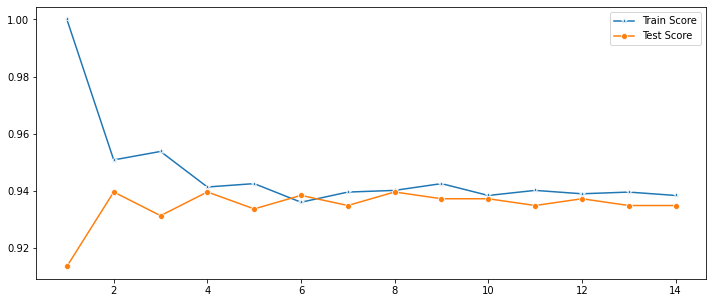

In [53]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')
#Axis labels are missing
# In the class - We defined error rate and shown error rate vs K - choose K which gives lowest error rate. 

Looking at the Plot we can see that best performance of the knn classifier is at k=4. Hence we set up our knn classifier with k=4.


In [54]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(4)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.9396449704142011

In [55]:
#select a sample from the test data to predict the output using the developed knn classifier
t=X_test.values[0]

In [56]:
t

array([ 0.67111772,  0.73296504,  0.25633606,  0.08972338, -0.47052942,
       -0.28238597])

In [57]:
print("Predicted Class: ",knn.predict(t.reshape(1,-1)))
print("True Class: ",y_test[0])

Predicted Class:  [0]
True Class:  0


You might be thinking that the knn classifier worked exceptionally well on the data. The accuracy achieved is 94% on the test data. But does accuracy in itelf give the complete picture about the classifier's performance? As studied in the class, let us look at some other performance metrics.

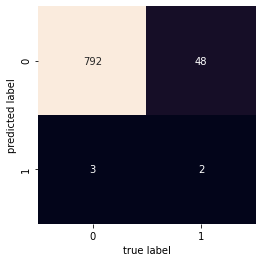

In [58]:
y_pred = knn.predict(X_test)
#build a confusion matrix to visualize the performance of the model using seaborn
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

You can see, that though the classifier predicted almost all the samples of class 0 correct, but failed completely on classifying the samples belonging to class 1. Why did this happen? 

On reviewing the histogram for the output variable, we see a highly imbalanced data. There are over 2000 samples belonging to class 0 whereas around 200 for class 1. This imbalance causes the classifier to be biased towards one class. Hence causing the poor performance. 

Accuracy in itself does not explain this effect. On looking at the confusion matrix, you would conclude that the classifier does a great job at predicting samples belong to class 0 but not well on class 1. Hence it is not a good classifier.

Since this dataset is highly skewed there is not much scope to improve the performance of any classifier by tuning. We will be needing additional data which would balance out the distribution of the two classes.

In [59]:
#import classification_report- (Precision, Recall, F1-score and support)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       795
           1       0.40      0.04      0.07        50

    accuracy                           0.94       845
   macro avg       0.67      0.52      0.52       845
weighted avg       0.91      0.94      0.92       845

